In [1]:
import torch
from feature_extractor import load_feature_extractor

In [2]:
model = load_feature_extractor()

---

In [3]:
x0 = torch.zeros((3,256,256))
x1 = torch.ones((3,256,256))
x2 = 2*torch.ones((3,256,256))
x3 = 3*torch.ones((3,256,256))
x01 = torch.cat((x0, x1),0)
x23 = torch.cat((x2, x3),0)
y01 = model(x01.unsqueeze(0))
y23 = model(x23.unsqueeze(0))

In [ ]:
x = torch.stack([x01,x23])
x.shape

In [ ]:
y = model(x)
y.shape

In [ ]:
torch.all(y[0] == y01)

In [ ]:
torch.all(y[1] == y23)

---

In [ ]:
x0 = torch.zeros((3,256,256))
x1 = torch.ones((3,256,256))
x01 = torch.cat((x0, x1),0)
y01 = model(x01.unsqueeze(0))

def tensor_mem(x):
    return x.element_size() * x.nelement() * 1e-9

In [ ]:
sizet = tensor_mem(y01)

In [ ]:
sizet

In [ ]:
sizet * 9573

In [ ]:
sizet * 16874

In [ ]:
sizet * 7630

In [ ]:
D = {
    'guatemala_train' : 1712 // 2,
    'guatemala_test' : 64 // 2,
    'guatemala_hold' : 206 // 2,
    'florence_train' : 12892 // 2,
    'florence_test' : 4536 // 2,
    'florence_hold' : 5668 // 2,
    'harvey_train' : 46028 // 2,
    'harvey_test' : 15430 // 2,
    'harvey_hold' : 14452 // 2,
    'matthew_train' : 27878 // 2,
    'matthew_test' : 8378 // 2,
    'matthew_hold' : 11672 // 2,
    'michael_train' : 45372 // 2,
    'michael_test' : 11314 // 2,
    'michael_hold' : 14316 // 2,
    'mexico_train' : 65542 // 2,
    'mexico_test' : 22822 // 2,
    'mexico_hold' : 15582 // 2,
    'midwest_train' : 17512 // 2,
    'midwest_test' : 5064 // 2,
    'midwest_hold' : 5216 // 2,
    'palu_train' : 62788 // 2,
    'palu_test' : 25120 // 2,
    'palu_hold' : 23670 // 2,
    'santa_train' : 25900 // 2,
    'santa_test' : 8452 // 2,
    'santa_hold' : 9558 // 2,
    'socal_train' : 20950 // 2,
    'socal_test' : 8544 // 2,
    'socal_hold' : 8444 // 2
}

import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.bar(range(len(D)), list(D.values()), align='center');
plt.xticks(range(len(D)), list(D.keys()), rotation=90);

In [ ]:
guatemala = D['guatemala_hold'] + D['guatemala_test'] + D['guatemala_train']
sizet * guatemala

In [ ]:
guatemala

In [ ]:
socal = D['socal_train'] + D['socal_test'] + D['socal_hold']
sizet * socal

In [ ]:
sizet * D['mexico_train']

---

In [8]:
import pandas as pd
from pathlib import Path

xbd_path = 'datasets/xbd'
subsets = ('/train_bldgs/', '/hold_bldgs/', '/test_bldgs/', '/tier3_bldgs/')
disaster_folders = os.listdir(xbd_path + subsets[0])

i_subset = 0
i_disaster = 5

print(list(Path(xbd_path + subsets[i_subset] + disaster_folders[i_disaster]).glob('*.csv*'))[0])
labels = pd.read_csv(list(Path(xbd_path + subsets[i_subset] + disaster_folders[i_disaster]).glob('*.csv*'))[0])
labels.columns = ['name', 'xcoords', 'ycoords', 'long', 'lat', 'class']
zone = lambda row: '_'.join(row['name'].split('_', 2)[:2])
labels['zone'] = labels.apply(zone, axis=1)
labels['zone'].value_counts()
#labels['zone'].value_counts()[labels['zone'].value_counts()==1].index.tolist()

datasets\xbd\train_bldgs\mexico-earthquake\mexico-earthquake_train_labels.csv


mexico-earthquake_00000048    1157
mexico-earthquake_00000003     932
mexico-earthquake_00000083     908
mexico-earthquake_00000052     854
mexico-earthquake_00000043     840
                              ... 
mexico-earthquake_00000166       7
mexico-earthquake_00000031       5
mexico-earthquake_00000192       4
mexico-earthquake_00000096       3
mexico-earthquake_00000155       2
Name: zone, Length: 121, dtype: int64

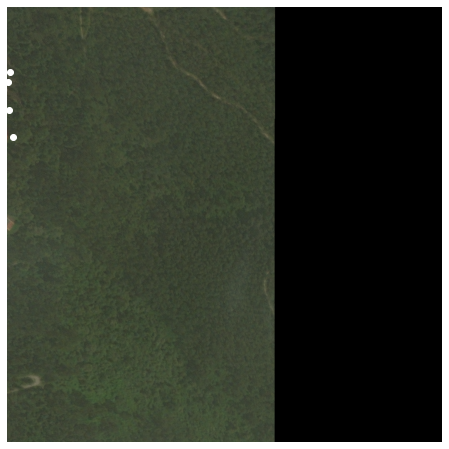

In [9]:
from visualization import plot_on_image

plot_on_image(labels, subsets[i_subset], 'mexico-earthquake_00000192')

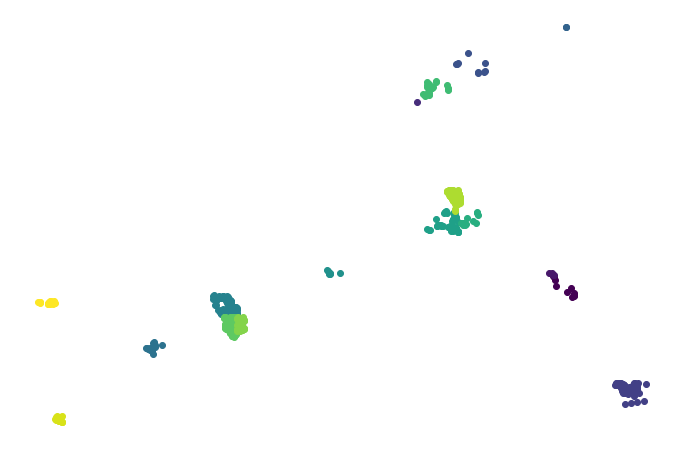

In [6]:
from visualization import plot_on_map

plot_on_map(labels, mapbox=False)

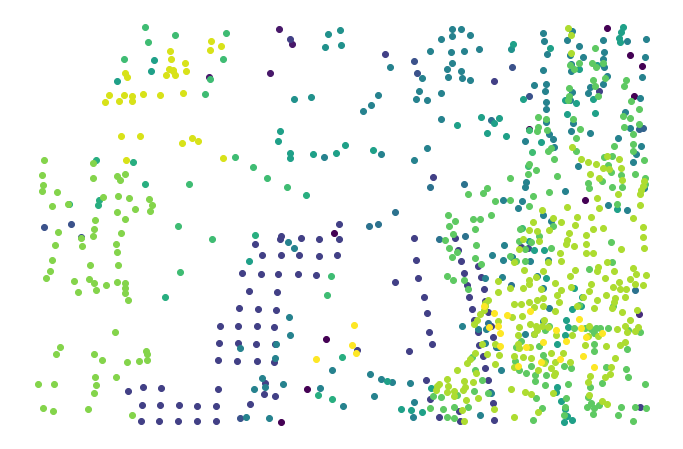

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from visualization import CmapString

cmap = CmapString(palette='viridis', domain=labels['zone'].values)

plt.figure(figsize=(12,8))
for _, row in labels.iterrows():
    plt.scatter(row['xcoords'], row['ycoords'], label=row['zone'], color=cmap.color(row['zone']))
plt.axis('off')
plt.show()

---

In [ ]:
import torch

a = torch.tensor([[0.8, 0.1, 0, 0],[0.7,0.6,0.3,0.2],[0.8,0.7,0.9,0.6]])

idx = torch.where(a < 0.5, 1, 0)

idx

In [ ]:
nz = torch.argmax(idx,dim=1)
nz

In [ ]:
torch.where(nz == 0, 4, nz)

---

In [1]:
import os
from pathlib import Path
import json
import pandas as pd

In [17]:
path = 'datasets/xbd/hold_bldgs/'
disaster_folders = os.listdir(path)
disaster = 'mexico-earthquake'

labels = pd.read_csv(list(Path(path + disaster).glob('*.csv*'))[0], index_col=0)
labels.drop(columns=['long','lat'], inplace=True)
zone = lambda row: '_'.join(row.name.split('_', 2)[:2])
labels['zone'] = labels.apply(zone, axis=1)

processed_files = []
zones = labels['zone'].value_counts()[labels['zone'].value_counts()>1].index.tolist()
for zone in zones:
     if not ((labels[labels['zone'] == zone]['class'] == 'un-classified').all() or \
            (labels[labels['zone'] == zone]['class'] != 'un-classified').sum() == 1):
        processed_files.append(f'{zone}.pt')

len(processed_files)

34

---

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.data import GraphSAINTNodeSampler
from tqdm import tqdm
from dataset import xBD
from model import DeeperGCN
from metrics import xview2_f1_score

with open('exp_settings.json', 'r') as JSON:
    settings_dict = json.load(JSON)

seed = settings_dict['seed']
batch_size = settings_dict['data']['batch_size']
num_steps = settings_dict['data']['saint_num_steps']
name = settings_dict['model']['name']

train_set = settings_dict['train_set']
train_roots = []
test_roots = []
for set in train_set:
    if set == 'mexico-earthquake':
        train_roots.append(settings_dict['data']['mexico_train_root'])
        test_roots.append(settings_dict['data']['mexico_test_root'])
    elif set == 'palu-tsunami':
        train_roots.append(settings_dict['data']['palu_train_root'])
        test_roots.append(settings_dict['data']['palu_test_root'])
    elif set == 'hurricane-matthew':
        train_roots.append(settings_dict['data']['matthew_train_root'])
        test_roots.append(settings_dict['data']['matthew_test_root'])
    elif set == 'santa-rosa-wildfire':
        train_roots.append(settings_dict['data']['rosa_train_root'])
        test_roots.append(settings_dict['data']['rosa_test_root'])

mexico_hold = settings_dict['data']['mexico_hold_root']

hidden_units = settings_dict['model']['hidden_units']
num_layers = settings_dict['model']['num_layers']
dropout_rate = settings_dict['model']['dropout_rate']
lr = settings_dict['model']['lr']
n_epochs = settings_dict['epochs']
starting_epoch = settings_dict['starting_epoch']
path = settings_dict['model']['path']
save_best_only = settings_dict['save_best_only']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
dataset = xBD(mexico_hold, 'mexico-earthquake', 'hold')
model = DeeperGCN(dataset.num_node_features, dataset.num_edge_features, hidden_units, dataset.num_classes, num_layers, dropout_rate)
model_path = path + '/' + name + '_best.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)

In [4]:
model

DeeperGCN(
  (node_encoder): Linear(in_features=131072, out_features=256, bias=True)
  (edge_encoder): Linear(in_features=2, out_features=256, bias=True)
  (layers): ModuleList(
    (0): DeepGCNLayer(block=res+)
    (1): DeepGCNLayer(block=res+)
    (2): DeepGCNLayer(block=res+)
    (3): DeepGCNLayer(block=res+)
    (4): DeepGCNLayer(block=res+)
    (5): DeepGCNLayer(block=res+)
    (6): DeepGCNLayer(block=res+)
  )
  (lin): Linear(in_features=256, out_features=4, bias=True)
)

In [5]:
with torch.no_grad():
    model.eval()

    ys = []
    outs = []

    for data in dataset:
        sampler = GraphSAINTNodeSampler(data, batch_size=batch_size, num_steps=num_steps, num_workers=2)
        for subdata in sampler:
            subdata = subdata.to(device)
            outs.append(model(subdata.x, subdata.edge_index, subdata.edge_attr).cpu())
            ys.append(subdata.y.cpu())

    outs = torch.cat(outs)
    ys = torch.cat(ys)

In [6]:
outs

tensor([[9.9949e-01, 9.0918e-03, 5.1355e-04, 5.7985e-04],
        [9.9950e-01, 8.2339e-03, 5.1392e-04, 5.7424e-04],
        [9.9950e-01, 8.2234e-03, 5.1391e-04, 5.7406e-04],
        ...,
        [9.9950e-01, 8.2336e-03, 5.1390e-04, 5.7418e-04],
        [9.9949e-01, 9.0893e-03, 5.1354e-04, 5.7979e-04],
        [9.9950e-01, 8.2336e-03, 5.1390e-04, 5.7418e-04]])

In [7]:
ys

tensor([[1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        ...,
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0]])

In [11]:
from metrics import parse_ordinal_output

parse_ordinal_output(outs)

tensor([1, 1, 1,  ..., 1, 1, 1])

In [12]:
parse_ordinal_output(ys)

tensor([1, 1, 1,  ..., 1, 1, 1])

In [16]:
import numpy as np

unique, counts = np.unique(parse_ordinal_output(ys).numpy(), return_counts=True)

print(np.asarray((unique, counts)).T)

[[    1 18954]
 [    2   101]
 [    3    14]]


In [17]:
import numpy as np

unique, counts = np.unique(parse_ordinal_output(outs).numpy(), return_counts=True)

print(np.asarray((unique, counts)).T)

[[    1 19069]]


---

In [15]:
from sklearn.metrics import f1_score

y_pred = [1, 1, 1, 2, 1, 2]
y_true = [1, 1, 1, 2, 2, 3]
f1_classes = f1_score(y_true, y_pred, average=None)
f1_classes

array([0.85714286, 0.5       , 0.        ])

In [16]:
epsilon = 1e-6
len(f1_classes) / sum((f1+epsilon)**-1 for f1 in f1_classes)

2.999990500046166e-06